# Introduction

Brian & barbara wanted a boxplot of genes detected (>= 1.0 FPKM) for the 920 cells in the muscle development paper

Box plot (see seaborn) y axis is number of genes > 1 fpkm.
can use protein coding. should include that in axis.

In [1]:
import numpy
import pandas
import sys
import os
from collections import Counter

In [2]:
LRSC = os.path.expanduser('~diane/proj/long-rna-seq-condor')
if LRSC not in sys.path:
    sys.path.append(LRSC)

In [3]:
import seaborn
from matplotlib import pyplot
from c1extra import boxplot, read_remote_sheet, get_cluster_maps, ODFReader

In [4]:
from woldrnaseq.models import load_gtf_cache
from woldrnaseq.gtfcache import protein_coding_gene_ids

In [5]:
from find_bigwigs import read_peng_20180710_cluster_memberships

In [6]:
%matplotlib inline

In [7]:
annotation = load_gtf_cache(os.path.expanduser('~diane/proj/genome/mm10-M4-male/mm10-M4-male.h5'))
protein_coding = protein_coding_gene_ids(annotation)

In [8]:
genes_asof17 = pandas.read_csv('C1_mouse_combined_asof_run17.tsv',
                               dtype={0: str},
                               index_col=0,
                               sep='\t')

In [9]:
C1_library_number_filename = 'C1_single_cells_library_number_cell_type_annotation_Jan13_2019.ods'
#book = ODFReader('C1_single_cells_library_number_cell_type_annotation_Jan13_2019.ods')
#clusters = book.parse('Sheet1')
clusters = pandas.read_excel(C1_library_number_filename, 'Sheet1', engine='odf')
clusters = clusters[['cell_ID', 'cell type cluster 920']]
clusters.shape

(920, 2)

In [10]:
clusters.head()

,cell_ID,cell type cluster 920
0,18317_G10,DarkRed
1,20040_B1,DarkRed
2,20044_A10,DarkRed
3,20042_D4,DarkRed
4,18255_E8,DarkRed


Lets make sure that all the cells in the C1_single_cells_library_number_type_annotation_Jan13_2019 are in the full quantification data table

In [11]:
len(set(clusters.cell_ID).intersection(genes_asof17.columns))

920

In [12]:
protein_genes = genes_asof17.loc[protein_coding][clusters.cell_ID]
protein_genes.shape

(22032, 920)

In [13]:
sheet = read_remote_sheet(
    "https://woldlab.caltech.edu/nextcloud/index.php/s/Y5G5PTk5TNJaaPn/download", 
    'genes_by_cluster')

cluster_maps = get_cluster_maps(sheet, 'c1_class', 'c1_abbreviations')
cluster_label = cluster_maps['label']
cluster_color = cluster_maps['color']
cluster_order = cluster_maps['order']

In [14]:
expressed = protein_genes[protein_genes >= 1]
expressed.shape

(22032, 920)

Force merge two mesenchyme clusters together.

In [15]:
clusters.loc[clusters['cell type cluster 920'] == 'black', 'cell type cluster 920'] = 'grey'

In [16]:
clusters = clusters.merge(expressed.count().to_frame(name='count'), left_on='cell_ID', right_index=True)
clusters.to_csv("genes_detected_by_cluster_asof_run17.csv", index=False)

clusters['cluster_name'] = clusters['cell type cluster 920'].apply(lambda x: cluster_label[x])
#clusters['color'] = clusters['cell type cluster 920'].apply(lambda x: cluster_color[x])


In [22]:
Counter(clusters['cluster_name'])

Counter({'mus3': 23,
         'mus2': 38,
         'mus1': 54,
         'mes': 571,
         'chon': 57,
         'EMP': 5,
         'mac': 10,
         'endo': 7,
         'pchon': 139,
         'ecto': 8,
         'neur': 8})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


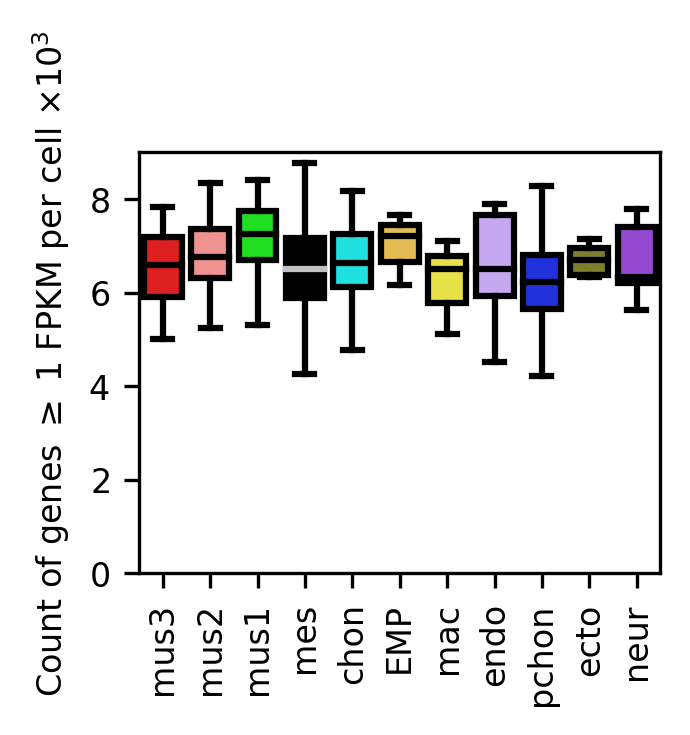

In [17]:
def plot_boxplot(expressed, color_dict, order, fontname='Arial'):
    font_size = 8.0
    mm2inch = 25.4
    
    f = pyplot.figure(figsize=(61/mm2inch, 60/mm2inch), dpi=300)
    ax = f.add_subplot(1,1,1)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)    
    _ = boxplot(x='cluster_name', y='count', 
                order=order,
                palette=color_dict, 
                data=expressed, 
                showfliers=False,
                ax=ax)
    #  
    _ = ax.set_ylabel('Count of genes $\geq$ 1 FPKM per cell $\\times$10$^3$', fontsize=font_size, fontname=fontname)
    _ = ax.set_xlabel('')
    
    labels = ax.get_yticklabels()
    for l in labels:
        l.set_fontsize(font_size)
        l.set_fontname(fontname)
    
    labels = ax.get_xticklabels()
    for l in labels:
        l.set_fontsize(font_size)
        l.set_fontname(fontname)
    ax.set_xticklabels(labels, rotation=90, ha='center')
    ax.set_ylim(0, 9000)
    ax.get_yaxis().get_offset_text().set_visible(False)

    f.tight_layout()
    return f, ax
f, ax = plot_boxplot(clusters, cluster_color, cluster_order)

In [19]:
if 0:
    f.savefig('count_of_genes_gt_1_fpkm_920cells.png')
    f.savefig('count_of_genes_gt_1_fpkm_920cells.eps')
    f.savefig('count_of_genes_gt_1_fpkm_920cells.svg')